In [1]:
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torchvision.models as models
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
import cv2

In [2]:
data_dir = 'drive/MyDrive/kaggle_mnist/digit-recognizer/'

for dirname, _, filenames in os.walk('drive/MyDrive/kaggle_mnist/digit-recognizer'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

drive/MyDrive/kaggle_mnist/digit-recognizer/test.csv
drive/MyDrive/kaggle_mnist/digit-recognizer/sample_submission.csv
drive/MyDrive/kaggle_mnist/digit-recognizer/train.csv


In [3]:
train_data = pd.read_csv(data_dir + 'train.csv')
test_data = pd.read_csv(data_dir + 'test.csv')

In [4]:
train_images = train_data.drop('label', axis=1).values.reshape(-1, 1, 28, 28)
test_images = test_data.values.reshape(-1, 1, 28, 28)
train_labels = train_data['label'].values

# nomalization
train_images = (train_images / 255.0).astype(np.float32)
test_images = (test_images / 255.0).astype(np.float32)

print(train_images.shape)
print(test_images.shape)

(42000, 1, 28, 28)
(28000, 1, 28, 28)


In [5]:
train_images, valid_images, train_labels, valid_labels = train_test_split(train_images, train_labels, test_size=0.1, random_state=42, stratify=train_labels)

train_tensor = torch.utils.data.TensorDataset(torch.tensor(train_images), torch.tensor(train_labels))
valid_tensor = torch.utils.data.TensorDataset(torch.tensor(valid_images), torch.tensor(valid_labels))
test_tensor = torch.utils.data.TensorDataset(torch.tensor(test_images))

train_loader = DataLoader(train_tensor, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_tensor, batch_size=64, shuffle=False)
test_loader = DataLoader(test_tensor, batch_size=100, shuffle=False)

In [6]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),  # (batch, 1, 28, 28)  ->  (batch, 32, 28, 28)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                                          # (batch, 32, 28, 28)  ->  (batch, 32, 14, 14)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # (batch, 32, 14, 14)  ->  (batch, 64, 14, 14)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                                          # (batch, 64, 14, 14)  ->  (batch, 64, 7, 7)
            nn.Flatten()
        )
        self.layer3 = nn.Sequential(
            nn.Linear(in_features=7*7*64, out_features=64),
            nn.Linear(in_features=64, out_features=10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x

In [7]:
# model = Network()
model = models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 173MB/s]


In [8]:
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
features = model.fc.in_features
model.fc = nn.Linear(features, 10, bias=True)

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device)

cuda:0


In [10]:
def softmax(x):
    return np.exp(x)/np.sum(np.exp(x), axis=1)[:, None]

In [16]:
test_pred = []

with torch.no_grad():
    for step in range(len(test_loader)):
        images = next(iter(test_loader))
        images[0] = images[0].to(device)

        predictions = model(images[0])

        test_pred.append(softmax(predictions.detach().cpu().numpy()))

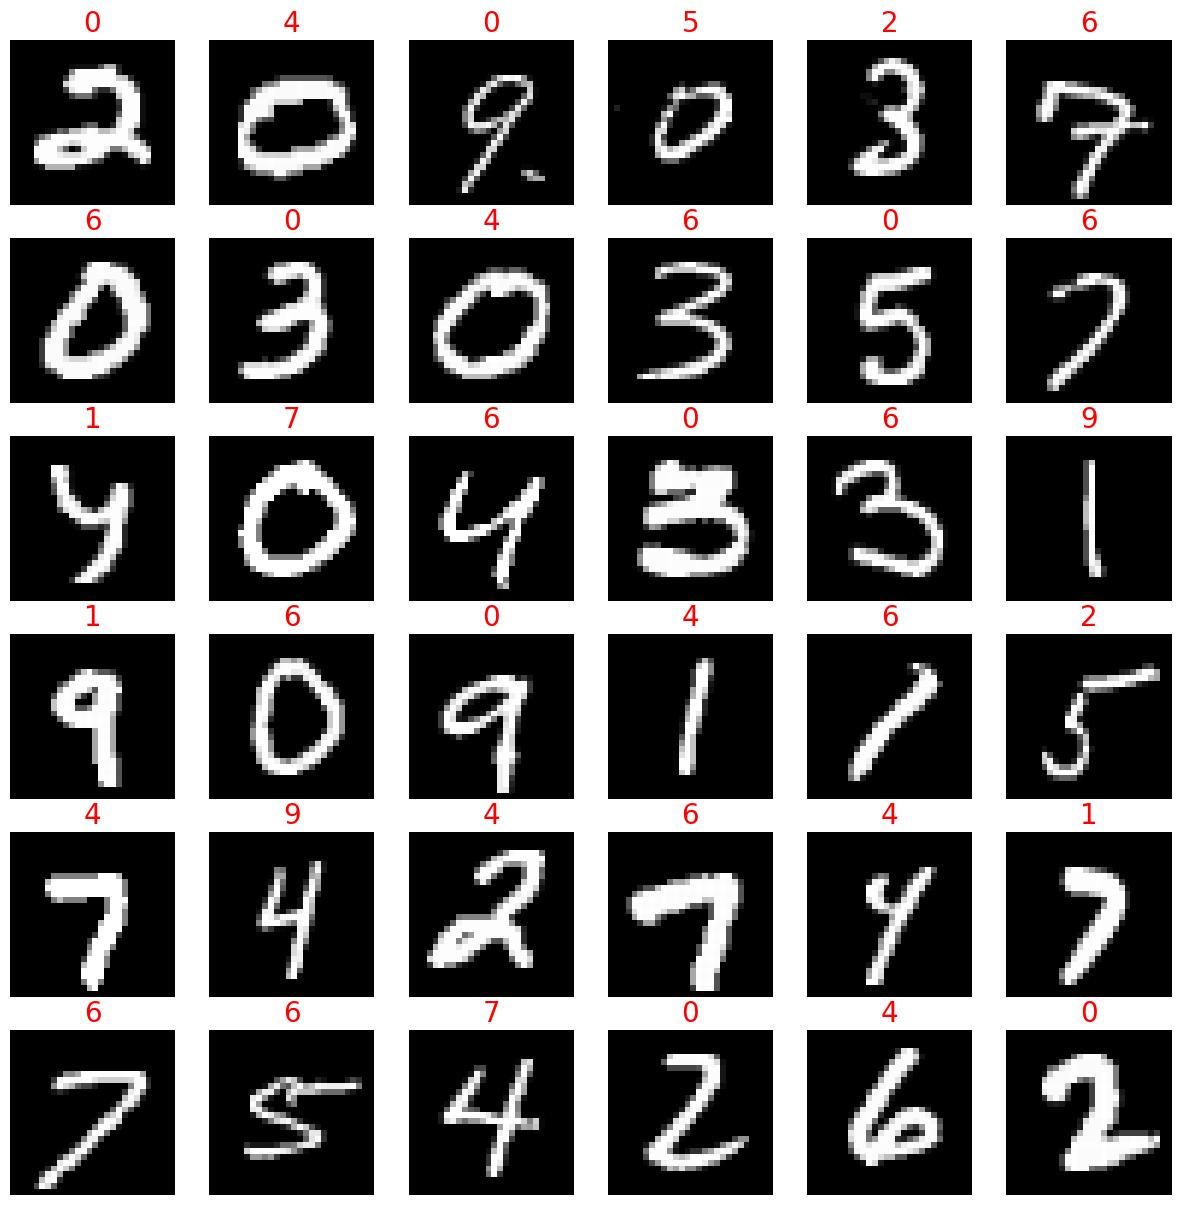

In [17]:
test_batch = next(iter(test_loader))[0]
test_X = test_batch.reshape(-1, 28, 28)[:36]
fig, ax = plt.subplots(nrows=6, ncols=6, figsize=(15, 15))

for i, image in enumerate(test_X):
    ax[i//6][i%6].axis('off'); ax[i//6][i%6].imshow(image, cmap='gray')
    ax[i//6][i%6].set_title(np.argmax(test_pred[0][i], axis=0), fontsize=20, color="red")

In [18]:
# loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [25]:
num_epochs = 20

for epoch in range(1, num_epochs + 1):

    train_loss = 0
    valid_loss = 0
    running_loss = 0

    # train
    model.train()
    for step in range(1, len(train_loader) + 1):
        images, labels = next(iter(train_loader))
        images = images.to(device)
        labels = labels.to(device)

        predictions = model(images)
        loss = criterion(predictions, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        sys.stdout.write('\r')
        sys.stdout.write("step: %d/%d  train_loss: %.5f" % (step, len(train_loader), train_loss/step))
        sys.stdout.flush()

    train_loss = train_loss / len(train_loader)
    print()
    print("epoch: {}  train_loss: {:.5f}".format(epoch, train_loss))

    # validation
    model.eval()
    with torch.no_grad():
        for step in range(1, len(valid_loader) + 1):
            images, labels = next(iter(valid_loader))
            images = images.to(device)
            labels = labels.to(device)

            predictions = model(images)
            loss = criterion(predictions, labels)

            valid_loss += loss.item()
            sys.stdout.write('\r')
            sys.stdout.write("step: %d/%d  valid_loss: %.5f" % (step, len(valid_loader), valid_loss/step))
            sys.stdout.flush()

    valid_loss = valid_loss / len(train_loader)
    print()
    print("epoch: {}  valid_loss: {:.5f}".format(epoch, valid_loss))
    print()

step: 591/591  train_loss: 0.16788
epoch: 1  train_loss: 0.16788
step: 66/66  valid_loss: 0.15235
epoch: 1  valid_loss: 0.01701

step: 591/591  train_loss: 0.07990
epoch: 2  train_loss: 0.07990
step: 66/66  valid_loss: 0.15142
epoch: 2  valid_loss: 0.01691

step: 591/591  train_loss: 0.05485
epoch: 3  train_loss: 0.05485
step: 66/66  valid_loss: 0.15169
epoch: 3  valid_loss: 0.01694

step: 591/591  train_loss: 0.04509
epoch: 4  train_loss: 0.04509
step: 66/66  valid_loss: 0.23242
epoch: 4  valid_loss: 0.02596

step: 591/591  train_loss: 0.03432
epoch: 5  train_loss: 0.03432
step: 66/66  valid_loss: 0.17364
epoch: 5  valid_loss: 0.01939

step: 591/591  train_loss: 0.02656
epoch: 6  train_loss: 0.02656
step: 66/66  valid_loss: 0.08277
epoch: 6  valid_loss: 0.00924

step: 591/591  train_loss: 0.02942
epoch: 7  train_loss: 0.02942
step: 66/66  valid_loss: 0.07049
epoch: 7  valid_loss: 0.00787

step: 591/591  train_loss: 0.02477
epoch: 8  train_loss: 0.02477
step: 66/66  valid_loss: 0.01014

In [27]:
test_pred = []
# softmax = nn.Softmax(dim=1)
with torch.no_grad():
    for step in range(len(test_loader)):
        images = next(iter(test_loader))
        images[0] = images[0].to(device)

        predictions = model(images[0])

        test_pred.append(softmax(predictions.detach().cpu().numpy()))

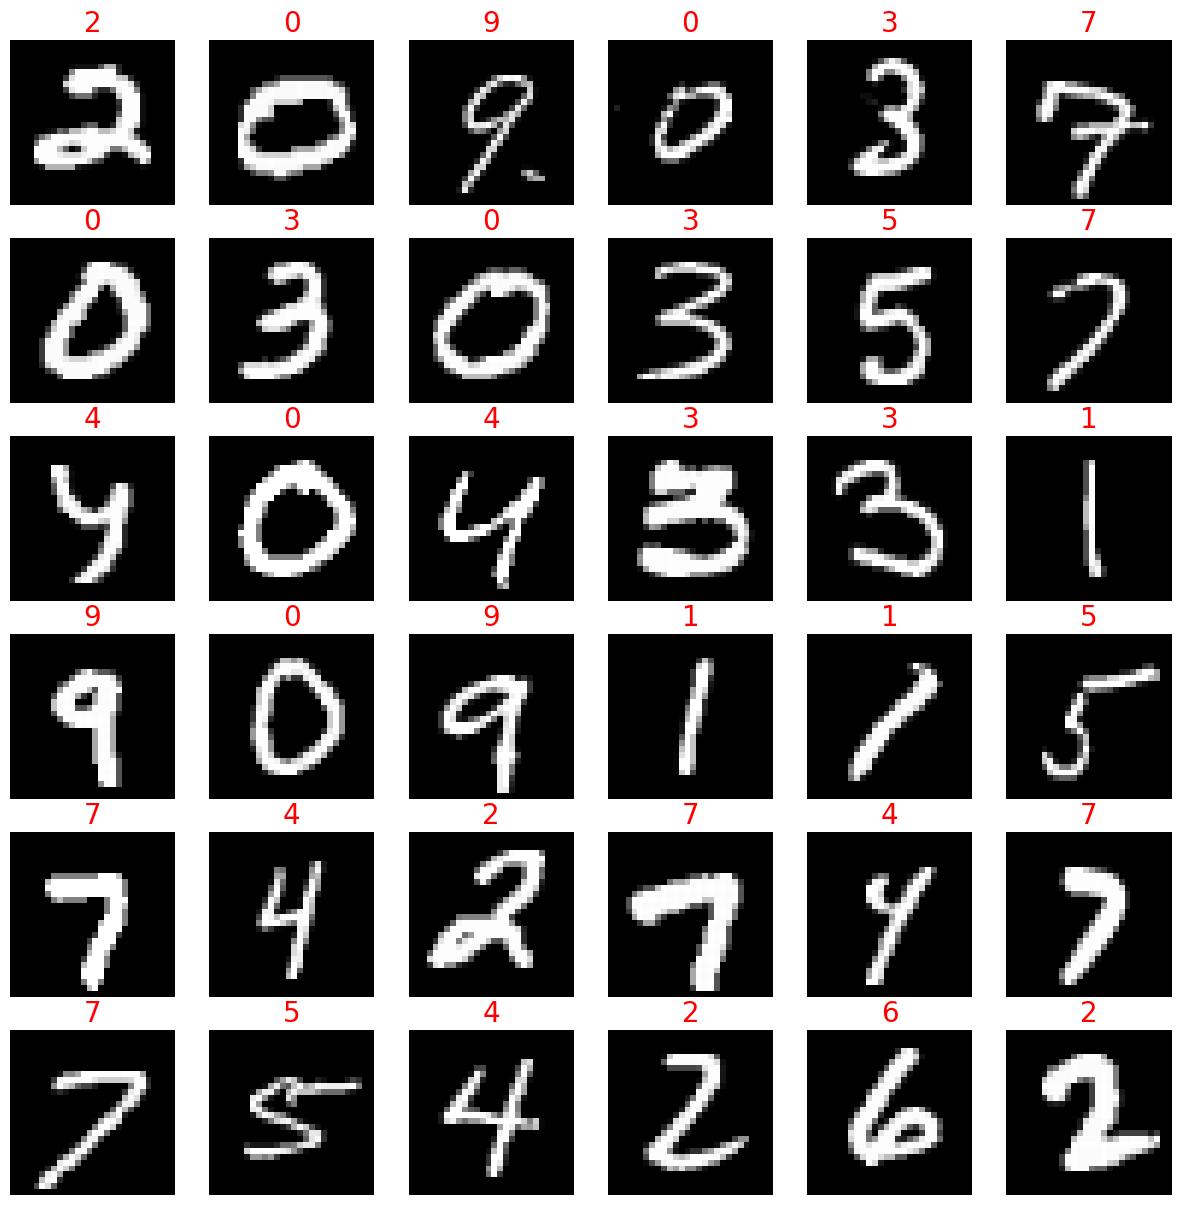

In [28]:
test_batch = next(iter(test_loader))[0]
test_X = test_batch.reshape(-1, 28, 28)[:36]
fig, ax = plt.subplots(nrows=6, ncols=6, figsize=(15, 15))

for i, image in enumerate(test_X):
    ax[i//6][i%6].axis('off'); ax[i//6][i%6].imshow(image, cmap='gray')
    ax[i//6][i%6].set_title(np.argmax(test_pred[0][i], axis=0), fontsize=20, color="red")

In [30]:
submission = pd.read_csv(data_dir + 'sample_submission.csv')
print(np.concatenate(test_pred, axis=0).shape)
submission["Label"] = np.argmax(np.concatenate(test_pred, axis=0), axis=1)

(28000, 10)


In [31]:
submission.head(15)

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
5,6,7
6,7,0
7,8,3
8,9,0
9,10,3
